# Bulk-like DGE analysis

## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


In [3]:
import scipy.cluster
from matplotlib_venn import venn2

In [4]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [5]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_210525_14h42/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.6.7


## Load data

In [6]:
adata = sc.read_h5ad('backups/mito_total_counts_filt_raw_32415x36601_210622_20h17.h5ad')

In [7]:
# load obs with classifier results
adata.obs = rz.load_df('backups/obs_info_32415x18_211010_11h51.npz')

In [8]:
# normalize
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


# Volcano plot of selected condition pairs

In [9]:
adata.obs.condition.unique()

array(['Control', 'KIPyV VLPs', 'MCPyV VLPs'], dtype=object)

In [10]:
# pairs to compare
pairs = {'2vs1':['Control','KIPyV VLPs'],
        '3vs1':['Control','MCPyV VLPs'],
        '3vs2':['KIPyV VLPs','MCPyV VLPs']}

In [11]:
# cell to consider (e.g. pass filter)
cmask = np.repeat(True, adata.shape[0]) #all in this case
print(cmask.sum())

32415


## Get enriched genes

### Get centroids

In [12]:
# get centroids
thelabel = 'condition'
centroids = rz.centroids(thelabel,adata[cmask])

### Prefilter genes

In [13]:
#label-free filter to remove very low abundance genes:
min_counts = 10
min_cells = 5

In [14]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

11414 genes passing abundance filter


### Statistical testing (+ saving results)

In [15]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for key,pair in pairs.items():
    mask1 = (meta[thelabel]==pair[0]).values
    mask2 = (meta[thelabel]==pair[1]).values
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    
    mwu_dict[key] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print(key, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
2vs1 done 20927
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
3vs1 done 21554
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
3vs2 done 22349
66.5364978313446


### Add fold-changes

In [16]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [17]:
# add fold-change
for value in mwu_dict.values():
    value['FC'] = (value['mean2']+pseudo)/(value['mean1']+pseudo)

## Plot volcanos

-1.025552771272997 3.614094851209176 x min max
1.5270332741345401e-06 296.1173722682662 y min max
-1.4218484383741197 3.6716703868845815 x min max
0.0001652405182043773 299.83295434678666 y min max
-0.6707808372709483 0.950519369280235 x min max
4.8472258134759146e-05 300.47093565204096 y min max


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


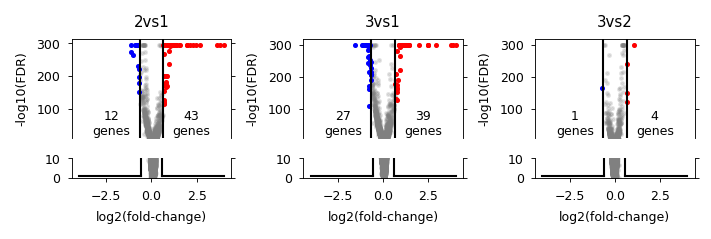

In [18]:
# threshold:
tsfc = 1.5
tsfdr = 0.05

ysplit = 10

#fig, gs = rz.startfig(20,7,rows=2,columns=3,return_first_ax=False,hrs=[10,2])
fig, gs = rz.startfig(12,4,rows=2,columns=3,return_first_ax=False,hrs=[10,2])

counter = -1
for key,value in mwu_dict.items():
    counter+=1
    
    # x and y axis
    x = np.log2(value['FC'])
    
    # some FDR are zeros, replace with smallest non-zero FDR
    ycorr = value['fdr'].copy()
    ycorr.replace(0.,ycorr[ycorr!=0].min(),inplace=True)
    y = -np.log10(ycorr)
    
    # for selecting limits
    print(min(x),max(x),'x min max')
    print(min(y),max(y),'y min max')
    
    # get up and down regulated gene numbers
    value['log2FC'] = np.log2(value['FC']) # add log2FC
    m1 = value['fdr']<tsfdr
    m2 = value['log2FC']>np.log2(tsfc)
    m3 = value['log2FC']<-np.log2(tsfc)
    mup = (m1&m2).values
    mdn = (m1&m3).values
        
    
    ### FIGURE TOP ###
    
    dotcol = '0.5'
    
    # figure
    a = fig.add_subplot(gs[0,counter])
    a.scatter(x,y,color=dotcol,s=2,alpha=0.2)
    
    # red and blue dots on top
    a.scatter(x[mup],y[mup],color='r',s=2)
    a.scatter(x[mdn],y[mdn],color='b',s=2)
    
    # labels
    a.set_title(key)
    a.set_ylabel('-log10(FDR)')
    
    # lims
    a.set_ylim(0,a.get_ylim()[1])
    a.set_xlim(-4,4)
    
    # threshold lines
    xleft = a.get_xlim()[0]
    xright = a.get_xlim()[1]
    ybot = a.get_ylim()[0]
    ytop = a.get_ylim()[1]

    # threshold lines
    lw = 1
    lcol = 'k'
    
    # left vertical
    a.plot((-np.log2(tsfc),-np.log2(tsfc)),(-np.log10(tsfdr),ytop),color=lcol,lw=lw)
    
    # right vertical
    a.plot((np.log2(tsfc),np.log2(tsfc)),(-np.log10(tsfdr),ytop),color=lcol,lw=lw)
    
    # left horizontal
    a.plot((xleft,-np.log2(tsfc)),(-np.log10(tsfdr),-np.log10(tsfdr)),color=lcol,lw=lw)
    
    # right horizontal
    a.plot((np.log2(tsfc),xright),(-np.log10(tsfdr),-np.log10(tsfdr)),color=lcol,lw=lw)
    
    # ylim
    a.set_ylim(ysplit,ytop)
    
    # not ticks
    a.set_xticks([])
    
    # splines
    rz.showspines(a,top=True,left=True,right=True)
    
    # number of genes up and down
    a.text(-2,ysplit,"%d\ngenes"%mdn.sum(),va='bottom',ha='center')
    a.text(2,ysplit,"%d\ngenes"%mup.sum(),va='bottom',ha='center')
    
    
    ### FIGURE BOTTOM ###
    
    # figure
    a = fig.add_subplot(gs[1,counter])
    a.scatter(x,y,color=dotcol,s=2,alpha=0.2)
    
    # red and blue dots on top
    a.scatter(x[mup],y[mup],color='r',s=2)
    a.scatter(x[mdn],y[mdn],color='b',s=2)
    
    # labels
    a.set_xlabel('log2(fold-change)')
    
    # threshold lines
    # left vertical
    a.plot((-np.log2(tsfc),-np.log2(tsfc)),(-np.log10(tsfdr),ytop),color=lcol,lw=lw)
    
    # right vertical
    a.plot((np.log2(tsfc),np.log2(tsfc)),(-np.log10(tsfdr),ytop),color=lcol,lw=lw)
    
    # left horizontal
    a.plot((xleft,-np.log2(tsfc)),(-np.log10(tsfdr),-np.log10(tsfdr)),color=lcol,lw=lw)
    
    # right horizontal
    a.plot((np.log2(tsfc),xright),(-np.log10(tsfdr),-np.log10(tsfdr)),color=lcol,lw=lw)
    
    # ylim
    a.set_ylim(ybot,ysplit)
    
    # splines
    rz.showspines(a,bottom=True,left=True,right=True)
    
    
gs.tight_layout(fig)
plt.savefig('postannotoutputs/volcanos.pdf')
plt.savefig('postannotoutputs/volcanos.png',dpi=600)

In [19]:
# save dataframe with results as excel files
chunkdict = {}
for key,value in mwu_dict.items():
    m1 = value['fdr']<tsfdr
    m2 = abs(value['log2FC'])>np.log2(tsfc)
    m3 = m1&m2
    print(key,m3.sum())
    chunk = value.loc[m3].sort_values('FC',ascending=False)
    chunk['up_or_down'] = chunk['log2FC']>0
    chunk['up_or_down'].replace(True,'up',inplace=True)
    chunk['up_or_down'].replace(False,'down',inplace=True)
    fname = 'postannotoutputs/bulk_DGE_%s_%.2f_%.2f.xlsx'%(key,tsfdr,tsfc)
    print(fname)
    chunk.to_excel(fname)
    
    chunkdict[key] = chunk

2vs1 55
postannotoutputs/bulk_DGE_2vs1_0.05_1.50.xlsx
3vs1 66
postannotoutputs/bulk_DGE_3vs1_0.05_1.50.xlsx
3vs2 5
postannotoutputs/bulk_DGE_3vs2_0.05_1.50.xlsx


## Heatmaps of enriched genes in given condition (incl. population info)

In [36]:
df = chunkdict['3vs1']
up3 = df.index[df['up_or_down']=='up']
print(len(up3))

df = chunkdict['2vs1']
up2 = df.index[df['up_or_down']=='up']
print(len(up2))

shared = [i for i in up3 if i in up2]
only2 = [i for i in up2 if i not in up3]
only3 = [i for i in up3 if i not in up2]
print(len(shared),len(only2),len(only3))

39
43
32 11 7


### Enriched in condition 3

In [37]:
condition = 'MCPyV VLPs'
key = '3vs1'
fname = 'heatmap_cond3_only_3vs1'

condmask = adata.obs['condition'] == condition
condmask = condmask.values
print(condmask.sum(),len(condmask))

# get centroids for this condition
# cell to consider (e.g. pass filter)
cmask = np.repeat(True, adata.shape[0]) #all in this case
print(cmask.sum())

# get centroids
thelabel = 'population'
centroids = rz.centroids(thelabel,adata[cmask&condmask])

11488 32415
32415


In [38]:
# select only columns with gene names:
genes = shared + only3
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

39


In [39]:
# use same column order as in other figures
colorder = ['IR', 'AII', 'HA', 'AI', 'Dead', 'SS', 'RS', 'MA', 'PA']

In [40]:
heat = heat[colorder]

-1.1444923 3.5361774
heatmap_cond3_only_3vs1


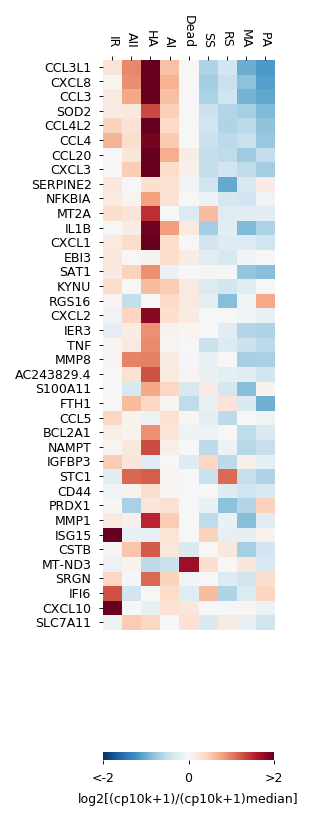

In [41]:
a,fig,gs = rz.startfig(5,15,frameon=False)

cmap = 'RdBu_r'
cbarlabel = 'log2[(cp10k+1)/(cp10k+1)median]'

vmin=-2
vmax=2
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270)
a.xaxis.tick_top()

# y ticks
a.set_yticks(range(heat.shape[0]))
a.set_yticklabels(heat.index)

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]
cbar.set_ticks(c)
cbar.set_ticklabels(clabs)
cbar.set_label(cbarlabel)


gs.tight_layout(fig)
print(fname)
plt.savefig('postannotoutputs/%s.pdf'%fname,dpi=600)

### Enriched on condition 2

In [42]:
condition = 'KIPyV VLPs'
key = '2vs1'
fname = 'heatmap_cond2_only_2vs1'

condmask = adata.obs['condition'] == condition
condmask = condmask.values
print(condmask.sum(),len(condmask))

# get centroids for this condition
# cell to consider (e.g. pass filter)
cmask = np.repeat(True, adata.shape[0]) #all in this case
print(cmask.sum())

# get centroids
thelabel = 'population'
centroids = rz.centroids(thelabel,adata[cmask&condmask])

10861 32415
32415


In [43]:
# select only columns with gene names:
genes = shared + only2
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

# apply same column order as above
heat = heat[colorder]

43


-0.97354496 2.8092551
heatmap_cond2_only_2vs1


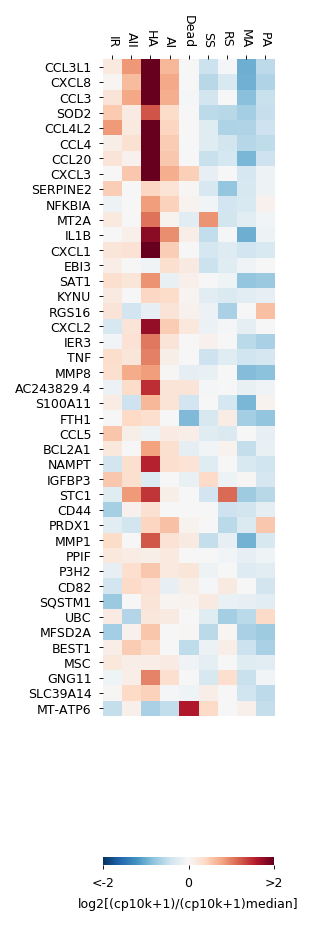

In [44]:
a,fig,gs = rz.startfig(5,17.1,frameon=False)

cmap = 'RdBu_r'
cbarlabel = 'log2[(cp10k+1)/(cp10k+1)median]'

vmin=-2
vmax=2
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270)
a.xaxis.tick_top()

# y ticks
a.set_yticks(range(heat.shape[0]))
a.set_yticklabels(heat.index)

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]
cbar.set_ticks(c)
cbar.set_ticklabels(clabs)
cbar.set_label(cbarlabel)


gs.tight_layout(fig)
print(fname)
plt.savefig('postannotoutputs/%s.pdf'%fname,dpi=600)

## Venn diagram showing overlap

In [47]:
from matplotlib_venn import venn2, venn2_circles

In [ ]:
###
3vs1':['Control','MCPyV VLPs'],
        '3vs2':['KIPyV VLPs','MCPyV VLPs']

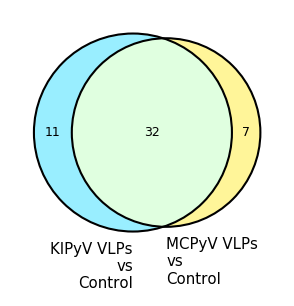

In [50]:
a,fig,gs = rz.startfig(5,5)
venn2([set(up2),set(up3)],set_labels=['KIPyV VLPs\nvs\nControl',
                                      'MCPyV VLPs\nvs\nControl'],ax=a,set_colors=('#00d5ff','#ffe600'))
venn2_circles([set(up2),set(up3)],ax=a,lw=1)


gs.tight_layout(fig)
plt.savefig('postannotoutputs/venn_upregulated.pdf')

In [51]:
print(shared)
print()
print(only3)
print()
print(only2)

['CCL3L1', 'CXCL8', 'CCL3', 'SOD2', 'CCL4L2', 'CCL4', 'CCL20', 'CXCL3', 'SERPINE2', 'NFKBIA', 'MT2A', 'IL1B', 'CXCL1', 'EBI3', 'SAT1', 'KYNU', 'RGS16', 'CXCL2', 'IER3', 'TNF', 'MMP8', 'AC243829.4', 'S100A11', 'FTH1', 'CCL5', 'BCL2A1', 'NAMPT', 'IGFBP3', 'STC1', 'CD44', 'PRDX1', 'MMP1']

['ISG15', 'CSTB', 'MT-ND3', 'SRGN', 'IFI6', 'CXCL10', 'SLC7A11']

['PPIF', 'P3H2', 'CD82', 'SQSTM1', 'UBC', 'MFSD2A', 'BEST1', 'MSC', 'GNG11', 'SLC39A14', 'MT-ATP6']


## Abundance fold-change barcharts

In [72]:
# color dictionary used in other figures
cdict = {
'AI': '#5eff0d',
'AII': '#49a300',
'Dead': '#ff9900',
'HA': '#114a0e',
'IR': '#ff0000',
'MA': '#00007f',
'PA': '#fff757',
'RS': '#0088ff',
'SS': '#0cf4e8'
}

In [73]:
refcond = 'Control'
pseudopct = 0.0

refcondmask = adata.obs['condition'] == refcond
refcondmask = refcondmask.values
print(refcondmask.sum())

refcount = adata.obs[refcondmask].groupby('population').count().iloc[:,0]
refpct = refcount/refcount.sum()*100.
refpct

10066


population
AI       1.122591
AII      1.142460
Dead     1.629247
HA       0.566263
IR       0.079475
MA      36.379893
PA      21.766342
RS      30.439102
SS       6.874627
Name: barcode, dtype: float64

### 2 vs 1

In [74]:
cond = 'KIPyV VLPs'
fname = 'abundance_fold_change_barchart_cond_'+cond
print(fname)

abundance_fold_change_barchart_cond_KIPyV VLPs


10861
population
AI      43.430623
AII     20.292791
Dead     6.380628
HA       3.498757
IR       0.184145
MA      10.625173
PA       3.397477
RS       1.620477
SS      10.569929
Name: barcode, dtype: float64


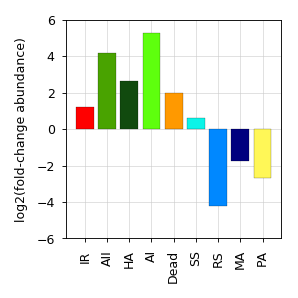

In [75]:
condmask = adata.obs['condition'] == cond
condmask = condmask.values
print(condmask.sum())

counts = adata.obs[condmask].groupby('population').count().iloc[:,0]
pct = counts/counts.sum()*100.
print(pct)

r = (pct+pseudopct)/(refpct+pseudopct)
logr = np.log2(r)
logr = logr[colorder]
colors = [cdict[i] for i in colorder]

a,fig,gs = rz.startfig(5,5)
x = np.arange(len(logr))
a.bar(x,logr,zorder=2,color=colors,edgecolor='k',lw=0.1)
a.set_xticks(x)
a.set_xticklabels(logr.index,rotation = 90);
a.grid(zorder=0)
a.set_ylim(-6,6)
a.set_ylabel('log2(fold-change abundance)')
gs.tight_layout(fig)

plt.savefig('postannotoutputs/%s.pdf'%fname)

### 3 vs 1

In [76]:
cond = 'MCPyV VLPs'
fname = 'abundance_fold_change_barchart_cond_'+cond
print(fname)

abundance_fold_change_barchart_cond_MCPyV VLPs


11488
population
AI      27.750696
AII     27.211003
Dead     4.735376
HA       5.771240
IR       2.332869
MA      14.554318
PA       3.542827
RS       1.418872
SS      12.682799
Name: barcode, dtype: float64


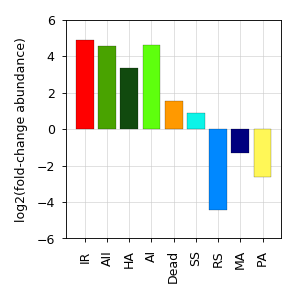

In [77]:
condmask = adata.obs['condition'] == cond
condmask = condmask.values
print(condmask.sum())

counts = adata.obs[condmask].groupby('population').count().iloc[:,0]
pct = counts/counts.sum()*100.
print(pct)

r = (pct+pseudopct)/(refpct+pseudopct)
logr = np.log2(r)
logr = logr[colorder]
colors = [cdict[i] for i in colorder]

a,fig,gs = rz.startfig(5,5)
x = np.arange(len(logr))
a.bar(x,logr,zorder=2,color=colors,edgecolor='k',lw=0.1)
a.set_xticks(x)
a.set_xticklabels(logr.index,rotation = 90);
a.grid(zorder=0)
a.set_ylim(-6,6)
a.set_ylabel('log2(fold-change abundance)')
gs.tight_layout(fig)

plt.savefig('postannotoutputs/%s.pdf'%fname)

### 3 vs 2

In [78]:
refcond = 'KIPyV VLPs'

refcondmask = adata.obs['condition'] == refcond
refcondmask = refcondmask.values
print(refcondmask.sum())

refcount = adata.obs[refcondmask].groupby('population').count().iloc[:,0]
refpct = refcount/refcount.sum()*100.

10861


In [79]:
cond = 'MCPyV VLPs'
fname = 'abundance_fold_change_barchart_cond_%s_vs_%s'%(cond,refcond)
print(fname)

abundance_fold_change_barchart_cond_MCPyV VLPs_vs_KIPyV VLPs


11488
population
AI      27.750696
AII     27.211003
Dead     4.735376
HA       5.771240
IR       2.332869
MA      14.554318
PA       3.542827
RS       1.418872
SS      12.682799
Name: barcode, dtype: float64


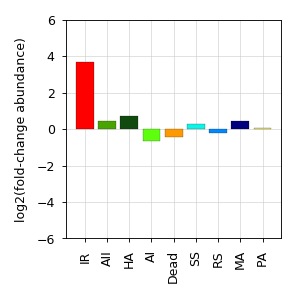

In [80]:
condmask = adata.obs['condition'] == cond
condmask = condmask.values
print(condmask.sum())

counts = adata.obs[condmask].groupby('population').count().iloc[:,0]
pct = counts/counts.sum()*100.
print(pct)

r = (pct+pseudopct)/(refpct+pseudopct)
logr = np.log2(r)
logr = logr[colorder]
colors = [cdict[i] for i in colorder]

a,fig,gs = rz.startfig(5,5)
x = np.arange(len(logr))
a.bar(x,logr,zorder=2,color=colors,edgecolor='k',lw=0.1)
a.set_xticks(x)
a.set_xticklabels(logr.index,rotation = 90);
a.grid(zorder=0)
a.set_ylim(-6,6)
a.set_ylabel('log2(fold-change abundance)')
gs.tight_layout(fig)

plt.savefig('postannotoutputs/%s.pdf'%fname)

In [288]:
!open postannotoutputs/